In [6]:
library(dplyr)
library(openxlsx)
library(survival)
library(survminer)
library(coxphf)

Loading required package: ggplot2

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma




In [2]:
# Load the dataset
data <- read.xlsx("data/Assignment Data Nov 2025.xlsx")

In [3]:
data

,id,treatment,time.pfs,event.pfs,TIS,APM,Cytotoxic.Cells,Cell.Adhesion,Macrophages,HRD,PD.L2,Claudin.Low
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,01-001,B,1.08493151,0,4.4739,8.9710,2.8083,8.1525,4.9905,5.8144,2.7206,0.0003
2,01-003,A,3.41917808,1,5.4583,12.5084,2.4482,7.8548,5.0558,6.5677,4.5264,0.0294
3,01-004,B,1.80821918,1,7.6395,15.6521,5.7542,4.2846,7.1589,5.2294,5.3222,2.8285
4,01-005,B,3.87945205,1,NA,NA,NA,NA,NA,NA,NA,NA
5,01-006,A,1.61095890,1,5.6696,10.6875,4.0832,8.8029,5.3213,4.4167,3.6242,1.1598
6,01-007,A,1.51232877,1,5.2504,10.3690,2.0198,9.6477,6.1885,6.2063,4.0936,0.0004
7,01-008,B,0.92054795,1,5.9613,11.3178,2.7684,7.6161,5.8491,5.8067,4.2596,0.1932
8,01-009,B,25.70958904,1,NA,NA,NA,NA,NA,NA,NA,NA
9,01-010,B,9.63287671,1,7.9301,13.6684,4.7302,0.0000,7.2249,4.5731,5.0524,2.9295


In [4]:
# remove the rows with missing values
df <- na.omit(data)

In [5]:
df

,id,treatment,time.pfs,event.pfs,TIS,APM,Cytotoxic.Cells,Cell.Adhesion,Macrophages,HRD,PD.L2,Claudin.Low
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,01-001,B,1.08493151,0,4.4739,8.9710,2.8083,8.1525,4.9905,5.8144,2.7206,0.0003
2,01-003,A,3.41917808,1,5.4583,12.5084,2.4482,7.8548,5.0558,6.5677,4.5264,0.0294
3,01-004,B,1.80821918,1,7.6395,15.6521,5.7542,4.2846,7.1589,5.2294,5.3222,2.8285
5,01-006,A,1.61095890,1,5.6696,10.6875,4.0832,8.8029,5.3213,4.4167,3.6242,1.1598
6,01-007,A,1.51232877,1,5.2504,10.3690,2.0198,9.6477,6.1885,6.2063,4.0936,0.0004
7,01-008,B,0.92054795,1,5.9613,11.3178,2.7684,7.6161,5.8491,5.8067,4.2596,0.1932
9,01-010,B,9.63287671,1,7.9301,13.6684,4.7302,0.0000,7.2249,4.5731,5.0524,2.9295
10,01-011,B,3.87945205,1,6.9951,12.9932,4.0255,9.1403,7.0278,6.2919,4.4129,0.0147
11,01-012,B,3.84657534,1,7.6325,12.8401,4.2440,9.4732,6.5829,6.7411,5.0174,0.2941


Ignoring unknown labels:
• colour : "Strata"


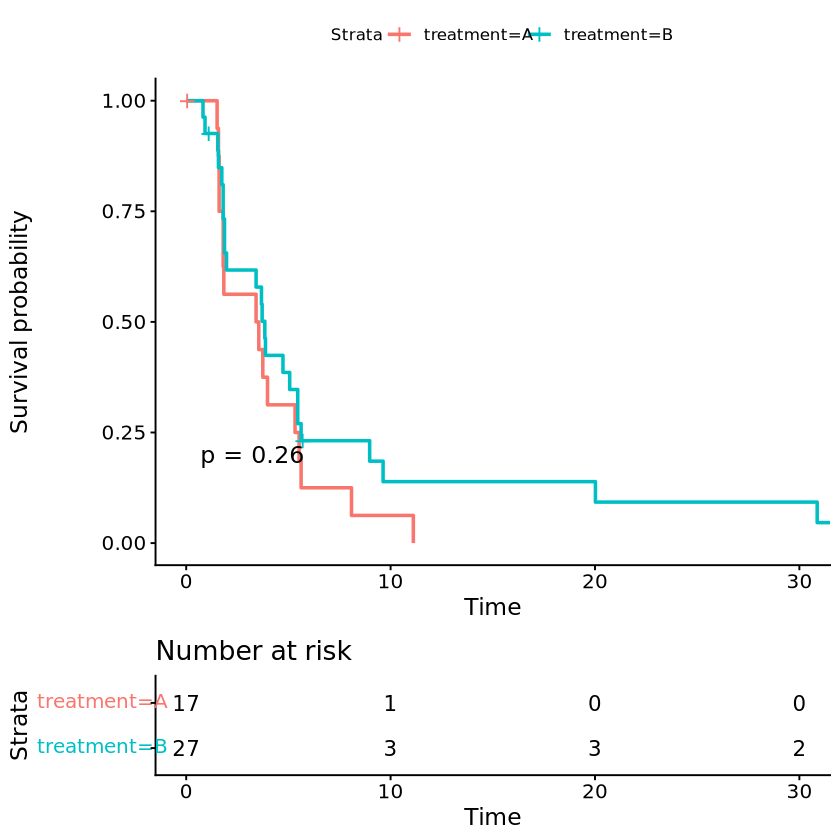

In [8]:
# draw KM plot to study the difference in PFS between the treatment groups

# Create a survival object
surv_object <- Surv(time = df$time.pfs, event = df$event.pfs)

# Fit the survival curves
fit <- survfit(surv_object ~ df$treatment)

# Plot the survival curves
ggsurvplot(fit, data = df, pval = TRUE, risk.table = TRUE)

In [9]:
# List the column names of the 8 gene expressions
cols_to_exclude <- c("treatment", "time.pfs", "event.pfs", "id")
cols_exp <- setdiff(colnames(df), cols_to_exclude)

In [10]:
cols_exp

[1] "TIS"             "APM"             "Cytotoxic.Cells" "Cell.Adhesion"  
[5] "Macrophages"     "HRD"             "PD.L2"           "Claudin.Low"

In [37]:
# Check whether Cox regression analyses have met the assumption of proportional hazards
ph_assumptions <- vector("list", length(cols_exp))
for (i in seq_along(cols_exp)) {
    gene <- cols_exp[i]
    cox_formula <- as.formula(sprintf("Surv(time.pfs, event.pfs) ~ %s + strata(treatment)", gene))
    model <- coxph(cox_formula, data = df)
    ph_test <- cox.zph(model)
    ph_assumptions[[i]] <- data.frame(
        gene = gene,
        p_value = ph_test$table[1, "p"],
        stringsAsFactors = FALSE
    )
}
ph_assumptions <- bind_rows(ph_assumptions)
ph_assumptions

gene,p_value
<chr>,<dbl>
TIS,0.9690752
APM,0.6267775
Cytotoxic.Cells,0.9436848
Cell.Adhesion,0.3037935
Macrophages,0.9034903
HRD,0.7543653
PD.L2,0.5904097
Claudin.Low,0.3680182


In [32]:
# Run Cox regression on each gene expression with PFS, stratifying the treatment
cox_gene_results <- vector("list", length(cols_exp))
for (i in seq_along(cols_exp)) {
    gene <- cols_exp[i]
    cox_formula <- as.formula(sprintf("Surv(time.pfs, event.pfs) ~ %s + strata(treatment)", gene))
    model <- coxph(cox_formula, data = df)
    beta <- coef(model)[1]
    se <- sqrt(vcov(model)[1, 1])
    cox_gene_results[[i]] <- data.frame(
        HR = exp(beta),
        HR_lower = exp(beta - 1.96 * se),
        HR_upper = exp(beta + 1.96 * se),
        p_value = summary(model)$coefficients[1, "Pr(>|z|)"],
        stringsAsFactors = FALSE
    )
}
cox_gene_results <- bind_rows(cox_gene_results)
cox_gene_results

,HR,HR_lower,HR_upper,p_value
,<dbl>,<dbl>,<dbl>,<dbl>
TIS,0.7628480,0.5670273,1.0262946,0.07369308
APM,0.7400094,0.5816535,0.9414778,0.01425094
Cytotoxic.Cells,0.6986305,0.4960194,0.9840029,0.04014207
Cell.Adhesion,1.0751782,0.9310604,1.2416038,0.32355132
Macrophages,0.6662358,0.4045021,1.0973245,0.11066955
HRD,1.0050754,0.6577921,1.5357078,0.98132629
PD.L2,0.6466131,0.4341052,0.9631500,0.03197793
Claudin.Low,0.8173325,0.6223500,1.0734030,0.14689231


In [40]:
# Still run Cox regression on each gene expression with PFS, stratifying the treatment, but considering the small sample issue
cox_gene_small_sample <- vector("list", length(cols_exp))
for (i in seq_along(cols_exp)) {
    gene <- cols_exp[i]
    cox_formula <- as.formula(sprintf("Surv(time.pfs, event.pfs) ~ %s + strata(treatment)", gene))
    penalized_fit <- coxphf::coxphf(cox_formula, data = df)
    beta_pena <- penalized_fit$coefficients[1]
    se_pena <- sqrt(diag(penalized_fit$var))[1]
    cox_gene_small_sample[[i]] <- data.frame(
        HR = exp(beta_pena),
        HR_lower = exp(beta_pena - 1.96 * se_pena),
        HR_upper = exp(beta_pena + 1.96 * se_pena),
        p_value = penalized_fit$prob[1],
        stringsAsFactors = FALSE
    )
}
cox_gene_small_sample <- bind_rows(cox_gene_small_sample)
cox_gene_small_sample

,HR,HR_lower,HR_upper,p_value
,<dbl>,<dbl>,<dbl>,<dbl>
TIS,0.7665290,0.5701434,1.0305596,0.07918711
APM,0.7520218,0.5956806,0.9493959,0.01646902
Cytotoxic.Cells,0.6988466,0.4976061,0.9814722,0.04124580
Cell.Adhesion,1.0697955,0.9309081,1.2294042,0.30978378
Macrophages,0.6551237,0.4007076,1.0710730,0.08984742
HRD,0.9794952,0.6464268,1.4841755,0.92183398
PD.L2,0.6286213,0.4235690,0.9329407,0.02452061
Claudin.Low,0.8174394,0.6271234,1.0655116,0.11523445
